# Análisis de Respuestas Humanas

Usaremos este notebook para el análisis y visualización de las evaluaciones que las personas nos han dado de Jais y Qwen.

In [ ]:
import pandas as pd
import re

df = pd.read_excel("../data/Evaluando respuestas en árabe.xlsx")
def clean_col(col: str) -> str:
    col = str(col)
    task = None
    m_task = re.search(r":\s*([^:\n\r]+)", col)
    if m_task:
        task = m_task.group(1).strip()
    else:
        task = "Tarea"

    crit = None
    m_crit = re.search(r"\[([^\]]+)\]", col)
    if m_crit:
        crit = m_crit.group(1).strip()
    else:
        crit = "Sin_criterio"

    # Cogemos elementos por aparición
    crit_low = crit.lower()
    if "gramat" in crit_low:
        crit_short = "gramatica"
    elif "fluidez" in crit_low or "naturalidad" in crit_low:
        crit_short = "fluidez"
    elif "registro" in crit_low:
        crit_short = "registro"
    elif "conceptual" in crit_low:
        crit_short = "conceptual"
    else:
        crit_short = re.sub(r"\s+", "_", crit.split("/")[0].strip().lower())
    return f"{task} | {crit_short}"

# Aplicar renombrado a todas las columnas
df = df.rename(columns={c: clean_col(c) for c in df.columns})

# Guardar el excel ya con columnas limpias
df.to_excel("../data/cuestionario_columnas_limpias.xlsx", index=False)


This section has been almost completely vibe-coded. We just wanted to focus on the results more than in the process.

                             col                   respuesta       tarea_raw  \
0           Tarea | sin_criterio  2026-01-10 21:44:12.521000           Tarea   
1           Tarea | sin_criterio  2026-01-11 15:28:10.901000           Tarea   
2     "misericordia" | gramatica                2 (mala/سيء)  "misericordia"   
3     "misericordia" | gramatica            3 (normal/طبيعي)  "misericordia"   
4       "misericordia" | fluidez            3 (normal/طبيعي)  "misericordia"   
5       "misericordia" | fluidez               4 (buena/جيد)  "misericordia"   
6      "misericordia" | registro                2 (mala/سيء)  "misericordia"   
7      "misericordia" | registro     1 (muy mala/سيء للغاية)  "misericordia"   
8    "misericordia" | conceptual                2 (mala/سيء)  "misericordia"   
9    "misericordia" | conceptual               4 (buena/جيد)  "misericordia"   
12  "misericordia" | gramatica.1                2 (mala/سيء)  "misericordia"   
13  "misericordia" | gramatica.1        

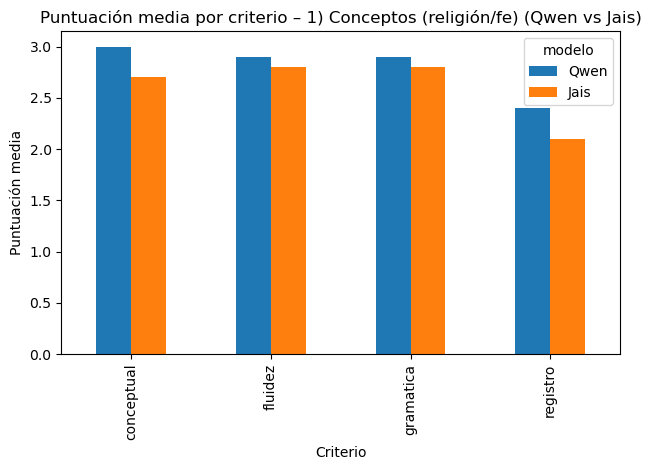

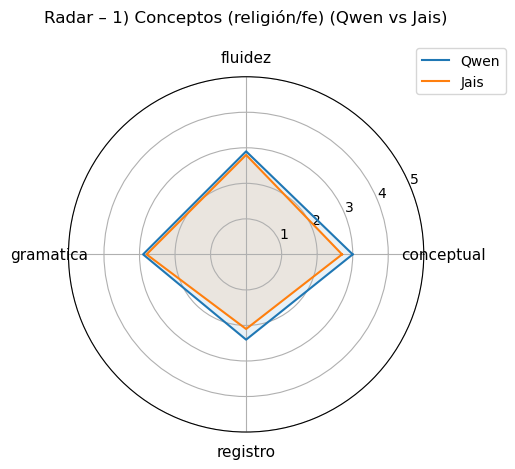

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# === Cargar Excel ===
xlsx_path = "../data/cuestionario_columnas_limpias.xlsx"
df_wide = pd.read_excel(xlsx_path)

# Columnas meta / puntuación
meta_cols = [c for c in df_wide.columns if "Marca temporal" in c or "Comentarios" in c]
value_cols = [c for c in df_wide.columns if c not in meta_cols and " | " in c]

# === Formato largo ===
df_long = (
    df_wide.melt(id_vars=meta_cols, value_vars=value_cols, var_name="col", value_name="respuesta")
    .dropna(subset=["respuesta"])
)

# Separar tarea y criterio desde "tarea | criterio"
df_long["tarea_raw"] = df_long["col"].str.split(" | ").str[0].str.strip()
df_long["criterio"]  = df_long["col"].str.split(" | ").str[-1].str.strip()

# Puntuación 1–5
df_long["puntuacion"] = pd.to_numeric(
    df_long["respuesta"].astype(str).str.extract(r"(\d)")[0],
    errors="coerce"
)
df_long = df_long.dropna(subset=["puntuacion"])
df_long["puntuacion"] = df_long["puntuacion"].astype(int)

# === Separar modelo por sufijo (.1) en el nombre de columna ===
# sin sufijo -> Qwen, con sufijo -> Jais
print(df_long.head(15))
df_long["modelo"] = df_long["criterio"].str.contains(r"\.\d+$", regex=True).map({False: "Qwen", True: "Jais"})

# Normalizar criterio (quitar .1)
df_long["criterio_base"] = df_long["criterio"].str.replace(r"\.\d+$", "", regex=True)

# === Clasificar tarea (según tu diseño) ===
concept_tokens = {'"misericordia"', '"justicia"', '"fe"', '"paciencia"', '"perdón"'}

def map_task(t):
    t = str(t).strip()
    if t in concept_tokens or t == "Tarea":
        return "1) Conceptos (religión/fe)"
    if t in ("La", "El") or t.startswith("Cómo"):
        return "2) Explicaciones (ideas/versos)"
    if t in ("Breve", "Párrafo", "Reflexión", "8"):
        return "3) Creativa (prompts religiosos)"
    return "Sin clasificar"

df_long["tarea_grupo"] = df_long["tarea_raw"].apply(map_task)

# === Graficar por tarea con Qwen vs Jais ===
out_dir = Path(".")  # o Path("/mnt/data") en Colab/Jupyter

task_order = [
    "1) Conceptos (religión/fe)",
    "2) Explicaciones (ideas/versos)",
    "3) Creativa (prompts religiosos)"
]

for task in task_order:
    sub = df_long[df_long["tarea_grupo"] == task].copy()

    # Por si sale algún criterio raro
    sub = sub[~sub["criterio_base"].str.contains("sin_criterio", case=False, na=False)]

    # medias por (modelo, criterio)
    means = sub.groupby(["modelo", "criterio_base"])["puntuacion"].mean().unstack("modelo").sort_index()

    # asegurar orden de columnas
    for col in ["Qwen", "Jais"]:
        if col not in means.columns:
            means[col] = np.nan
    means = means[["Qwen", "Jais"]]

    # --- Barras agrupadas ---
    ax = means.plot(kind="bar")
    ax.set_xlabel("Criterio")
    ax.set_ylabel("Puntuación media")
    ax.set_title(f"Puntuación media por criterio – {task} (Qwen vs Jais)")
    plt.tight_layout()
    plt.savefig(out_dir / f"bar_modelos_tarea_{task[0]}.png", dpi=200, bbox_inches="tight")
    plt.show()

    # --- Radar (dos líneas) ---
    labels = means.index.tolist()
    N = len(labels)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    plt.figure()
    ax = plt.subplot(111, polar=True)

    for model in ["Qwen", "Jais"]:
        vals = means[model].tolist()
        vals += vals[:1]
        ax.plot(angles, vals, label=model)
        ax.fill(angles, vals, alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=11)
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_ylim(0, 5)
    ax.set_title(f"Radar – {task} (Qwen vs Jais)", pad=20)
    ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.1))
    plt.tight_layout()
    plt.savefig(out_dir / f"radar_modelos_tarea_{task[0]}.png", dpi=200, bbox_inches="tight")
    plt.show()
